# Homework 3

## Data Preparation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\mab03\Desktop\ML-Zoomcamp\03-classification\course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [4]:
numerical = df.select_dtypes(exclude=['object']).columns.tolist()
numerical 

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [5]:
# Replace categorical features with 'NA'
for col in categorical:
    df[col] = df[col].fillna('NA')

In [6]:
df.isnull().sum()

lead_source                   0
industry                      0
number_of_courses_viewed      0
annual_income               181
employment_status             0
location                      0
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
# Replace numerical features with 0.0
for col in numerical:
    df[col] = df[col].fillna(0.0)

In [8]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
# Split the data
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values


del df_train['converted']
del df_val['converted']
del df_test['converted']

print(len(df_train), len(df_val), len(df_test))

876 293 293


# Question 1
ROC AUC Feature Importance

In [11]:
from sklearn.metrics import roc_auc_score

numerical = ['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',]

for var in numerical:
    print(f"{var}: {round(roc_auc_score(y_train,df_train[var]),3)}")

number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


# Question 2
Training the model

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

# Whats the AUC of this model on the validation
print(f"AUC: {round(roc_auc_score(y_val,y_pred),2)}")

AUC: 0.82


# Question 3
Precision and Recall

In [14]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

scores = []

thresholds = np.linspace(0, 1, 101)
thresholds
for t in thresholds:
    # tp = ((y_pred >= t) & (y_val == 1)).sum()
    # fp = ((y_pred >= t) & (y_val == 0)).sum()
    # fn = ((y_pred < t) & (y_val == 1)).sum()
    # tn = ((y_pred < t) & (y_val == 0)).sum()
    # scores.append((t, tp, fp, fn, tn))
    pr = precision_score(y_val, y_pred>=t,zero_division=1.0)
    rec = recall_score(y_val,y_pred>=t)
    scores.append((t,pr,rec))
    
scores_df = pd.DataFrame(scores)
scores_df.columns = ['threshold', 'precision', 'recall']

scores_df[:5]
    

,threshold,precision,recall
0,0.00,0.583618,1.0
1,0.01,0.583618,1.0
2,0.02,0.583618,1.0
3,0.03,0.583618,1.0
4,0.04,0.583618,1.0


64    0.77907
Name: precision, dtype: float64
64    0.783626
Name: recall, dtype: float64
64    0.64
Name: threshold, dtype: float64


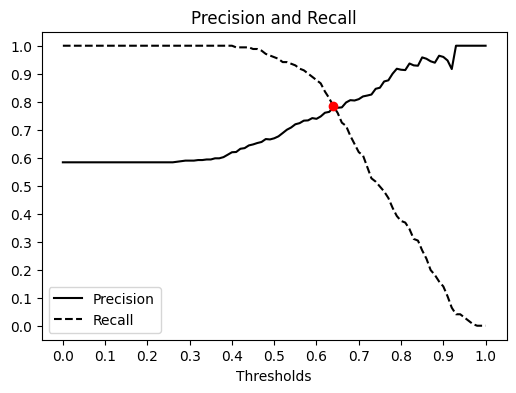

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

plt.plot(scores_df.threshold, scores_df.precision, color='black', linestyle='solid', label='Precision')
plt.plot(scores_df.threshold, scores_df.recall, color='black', linestyle='dashed', label='Recall')

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('Precision and Recall')

idx = np.argwhere(np.diff(np.sign(scores_df.precision - scores_df.recall))).flatten()
plt.plot(scores_df.threshold[idx], scores_df.recall[idx], 'ro')
plt.legend()

print(scores_df.precision[idx])
print(scores_df.recall[idx])
print(scores_df.threshold[idx])

plt.show()

# Question 4
F1 Score

In [16]:
f1_scores = []
for idx,row in scores_df.iterrows():
    f1_scores.append((2 * row.precision * row.recall) / (row.precision+row.recall))
    
scores_df['f1'] = f1_scores

print(scores_df.loc[scores_df['f1'] == scores_df['f1'].max()])

    threshold  precision    recall      f1
57       0.57   0.732394  0.912281  0.8125


# Question 5
5-Fold CV

In [17]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [18]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# train_idx, val_idx = next(kfold.split(df_train_full))
# len(train_idx), len(val_idx)

In [19]:
aucs = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.converted.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [20]:
print('%.3f +- %.3f' % (np.mean(aucs), np.std(aucs)))

0.822 +- 0.036


# Question 6
Hyperparameter Tuning

In [21]:
def train_reg(df, y, C = 1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [22]:
C = [0.000001, 0.001, 1]
for c in C:
    aucs = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        y_train = df_train.converted.values

        df_val = df_train_full.iloc[val_idx]
        y_val = df_val.converted.values

        dv, model = train_reg(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        rocauc = roc_auc_score(y_val, y_pred)
        aucs.append(rocauc)
    print('%.3f +- %.3f' % (np.mean(aucs), np.std(aucs)))
        

0.560 +- 0.024
0.867 +- 0.029
0.822 +- 0.036
